In [3]:
def get_tuples(text):
    text=text.replace(' ', '')
    text=text.replace('\n', '')
    text=text.replace('{', '')
    text=text.replace('}', '')
    vals = text.split(',')
    l = len(vals)-1
    data = np.zeros(shape=(l//2,2))
    for idx, v in enumerate(vals[:-1]):
        v=float(v)
        if idx<l//2:
            data[idx,0] = v
        else:
            data[idx%(l//2),1] = v
    return data


In [2]:
import re
import numpy as np

def make_table(bg, t):
    text = ""
    print(f"nr-eesm-t{t}-bg{bg}.cc")
    with open(f"nr-eesm-t{t}-bg{bg}.cc") as fr:
        for l in fr.readlines():
            comment = l.find('//')
            if comment >=0:
                text+=(l[:comment]+'\n')
            else:
                text+=l
    matches = list(re.finditer("{([0-9]*)U, (\n)*.*NrEesmErrorModel::DoubleTuple{", text))[2:]
    mcs = 2
    data = {}
    last_cbs =  -1
    for i in range(len(matches)-1):
        m = matches[i]
        start,end = m.span()[1], matches[i+1].span()[0]
        cbs = int(m.groups()[0])
        if cbs < last_cbs:
            mcs+=1
        if mcs not in data.keys():
            data[mcs] = {}
        tuple = get_tuples(text[start:end])
        data[mcs][cbs] = tuple
        last_cbs = cbs
    cbs = int(matches[-1].groups()[0])
    try:
        data[mcs][cbs]= get_tuples(text[matches[-1].span()[1]:-1])
    except:
        print(text[matches[-1].span()[1]:-1])
    return data

def save_snrmcs_table(bg, t, data):
    lena_table = []
    for mcs in data.keys():
        mcbs = max(data[mcs].keys())
        for e in data[mcs][mcbs]:
            if e[1]<=0.1:
                lena_table.append([mcs, mcbs, *e])
                break
    lena_table = np.array(lena_table)
    np.savetxt(f'lena_table-t{t}-bg{bg}.csv', lena_table, header='mcs, cbs, sinr, bler', delimiter=',', fmt=['%d', '%.2f', '%.2f', '%.3f'])

In [350]:
for bg in [1,2]:
    for t in [1,2]:
        data = make_table(bg, t)
        save_snrmcs_table(bg, t, data)

nr-eesm-t1-bg1.cc
nr-eesm-t2-bg1.cc
nr-eesm-t1-bg2.cc
nr-eesm-t2-bg2.cc


## OAI

In [5]:
import pandas as pd
oai_mcs_table = []
for mcs in range(29):
    df = pd.read_csv(f'../OAI/mcs{mcs}_awgn_5G.csv', sep=';')
    df['bler'] = df.err0/df.trials0
    min_snr = df[df.bler<0.1].SNR.values[0]
    #print(min_snr[['SNR', 'bler']])
    oai_mcs_table.append([mcs, min_snr])
oai_mcs_table = np.array(oai_mcs_table)

# Shannon

In [6]:
import math as m
se_table2 = [0.2344, 0.3770, 0.6016, 0.8770,
            1.1758, 1.4766, 1.6943, 1.9141, 
            2.1602, 2.4063, 2.5703, 2.7305, 
            3.0293, 3.3223, 3.6094, 3.9023,
            4.2129, 4.5234, 4.8164, 
            5.1152, 5.3320, 5.5547, 5.8906,
            6.2266, 6.5703, 6.9141,
            7.1602, 7.4063]


se_table1 = [0.2344, 0.3066, 0.3770, 0.4902, 0.6016, 0.7402, 0.8770, 
             1.0273, 1.1758, 1.3262, 1.3281, 1.4766, 1.6953, 1.9141, 
             2.1602, 2.4063, 2.5703, 2.5664, 2.7305, 
            3.0293, 3.3223, 3.6094, 3.9023,
            4.2129, 4.5234, 4.8164, 
            5.1152, 5.3320, 5.5547,]



shannon_3gpp_table2 = 10*np.log(np.power(2,se_table2)-1)/np.log(10)
shannon_3gpp_table1 = 10*np.log(np.power(2,se_table1)-1)/np.log(10)
print(len(shannon_3gpp_table1))
print(len(shannon_3gpp_table2))


29
28


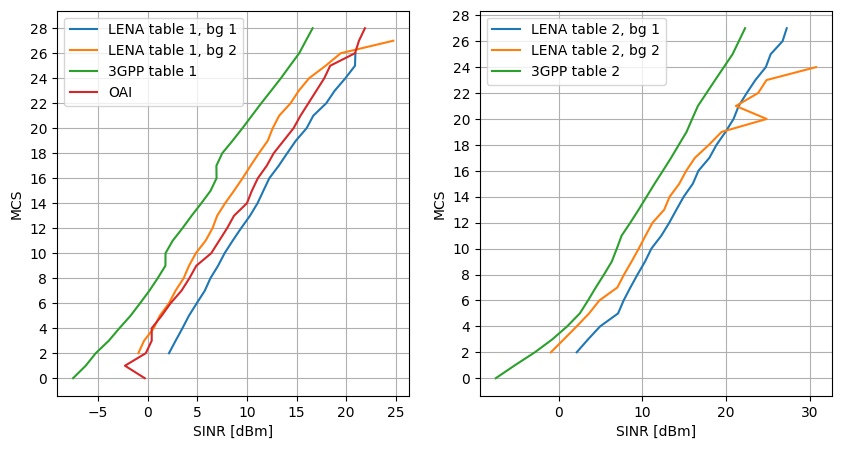

In [9]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
for t in [1,2]:
    ax = plt.subplot(1,2,t)
    for bg in [1,2]:
        table = np.loadtxt(f'lena_table-t{t}-bg{bg}.csv', delimiter=',')
        ax.plot(table[:,2], table[:,0], label=f'LENA table {t}, bg {bg}')
    if t==1:
        ax.plot(shannon_3gpp_table1, range(0,29), label='3GPP table 1')
        ax.plot(oai_mcs_table[:, 1], oai_mcs_table[:, 0], label='OAI')
    if t==2:
        ax.plot(shannon_3gpp_table2, range(0,28), label='3GPP table 2')

    ax.set_yticks(np.arange(0,30, 2))
    ax.grid()
    ax.set_ylabel('MCS')
    ax.set_xlabel('SINR [dBm]')
    plt.legend()


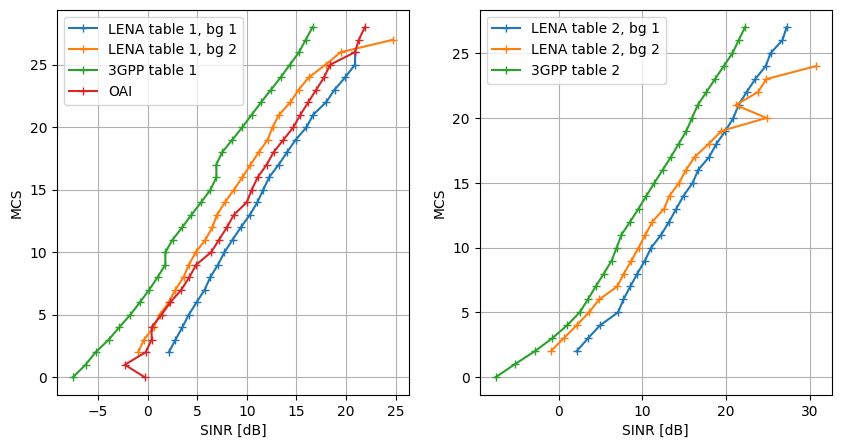

In [418]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
for t in [1,2]:
    ax = plt.subplot(1,2,t)
    for bg in [1,2]:
        table = np.loadtxt(f'lena_table-t{t}-bg{bg}.csv', delimiter=',')
        ax.plot(table[:,2], table[:,0],'+-' , label=f'LENA table {t}, bg {bg}')
    if t==1:
        ax.plot(shannon_3gpp_table1, range(0,29),'+-' , label='3GPP table 1')
        ax.plot(oai_mcs_table[:, 1], oai_mcs_table[:, 0],'+-' , label='OAI')
    if t==2:
        ax.plot(shannon_3gpp_table2, range(0,28),'+-' , label='3GPP table 2')

    #ax.set_yticks(np.arange(0,30, 2))
    ax.grid()
    ax.set_ylabel('MCS')
    ax.set_xlabel('SINR [dB]')
    plt.legend()
